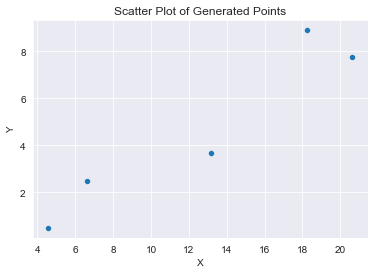

Generated Points: [(13.163143102893644, 3.67323594583126), (6.632980625446271, 2.4723227503964855), (4.557890215879873, 0.4844314615688501), (18.22346036378738, 8.895811118092137), (20.640286849263436, 7.736546199854336)]
Pairwise Distances: [[0.0, 6.639669757211648, 9.177082940036605, 7.272008127801758, 8.509886534162836]]


In [306]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import time
from typing import List

def generate_points(length, height, num_points):
    points = []
    for i in range(num_points):
        x = random.uniform(0, length)
        y = random.uniform(0, height)
        points.append((x, y))

    sns.set_style('darkgrid')
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(x=[p[0] for p in points], y=[p[1] for p in points])
    plt.title('Scatter Plot of Generated Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    #pairwise distances
    distances = []
    for i in range(num_points):
        row = []
        for j in range(num_points):
            dist = sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
            row.append(dist)
        distances.append(row)

    return points, distances

length = 30.0
height = 12.0
#num_points = 136
num_points = 5

source_points, source_distances = generate_points(length, height, num_points)
print('Generated Points:', source_points[:5])
print('Pairwise Distances:', source_distances[:1])

In [307]:
def calculate_length(route: List[int], distances: List[List[float]]) -> float:
    if len(route) != len(distances):
        raise ValueError("Route and distances lists must have the same length")
    
    length = 0
    for i in range(len(route) - 1):
        if route[i] < 0 or route[i] >= len(distances) or route[i+1] < 0 or route[i+1] >= len(distances):
            raise ValueError("Invalid index in route list")
        length += distances[route[i]][route[i+1]]
    length += distances[route[-1]][route[0]]
    return length


In [308]:
import numpy as np
import itertools

def find_shortest_route(points):

    num_points = len(points)
    distances = [[0] * num_points for _ in range(num_points)]
    for i in range(num_points):
        for j in range(num_points):
            dist = sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
            distances[i][j] = dist

    current_point = random.randint(0, num_points - 1)
    route = [current_point]

    while len(route) < num_points:
        nearest_neighbor = None
        nearest_distance = float('inf')
        for i in range(num_points):
            if i not in route and distances[current_point][i] < nearest_distance:
                nearest_neighbor = i
                nearest_distance = distances[current_point][i]

        
        route.append(nearest_neighbor)
        current_point = nearest_neighbor

    length = 0
    for i in range(num_points):
        length += distances[route[i]][route[(i + 1) % num_points]]

    return route, length

start_time = time.time()
shortest_route, shortest_length = find_shortest_route(source_points)
end_time = time.time()
bruteForceTime = end_time - start_time

In [309]:
from typing import List, Tuple
from math import sqrt
from random import randrange

def two_opt_algorithm(points: List[Tuple[float, float]], shortest_route: List[int], shortest_length: float, max_iterations: int=1000) -> Tuple[List[int], float]:

    point_dict = {point: i for i, point in enumerate(points)}
    indices = shortest_route.copy()

    def calculate_length(route: List[int]) -> float:
        length = 0
        for i in range(len(route) - 1):
            dist = sqrt((points[route[i]][0] - points[route[i+1]][0]) ** 2 + (points[route[i]][1] - points[route[i+1]][1]) ** 2)
            length += dist
        return length

    best_route = indices.copy()
    best_length = shortest_length
    for i in range(max_iterations):

        idx1, idx2 = sorted([randrange(len(points)) for _ in range(2)])
        new_route = indices[:idx1] + indices[idx1:idx2+1][::-1] + indices[idx2+1:]
        new_length = calculate_length(new_route)

        if new_length < best_length:
            best_route = new_route.copy()
            best_length = new_length

        indices = best_route.copy()

    optimized_route = [list(point_dict.keys())[list(point_dict.values()).index(idx)] for idx in best_route]
    optimized_route = [points.index(point) + 1 for point in optimized_route]

    return optimized_route, best_length

start_time = time.time()
twoopt_optimized_route, twoopt_optimized_length = two_opt_algorithm(source_points, shortest_route, shortest_length)
end_time = time.time()
twoOptTime = end_time - start_time


In [310]:
def three_opt_algorithm(points: List[Tuple[float, float]], shortest_route: List[int], shortest_length: float, max_iterations: int=1000) -> Tuple[List[int], float]:

    n = len(points)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
            dist_matrix[j][i] = dist_matrix[i][j]

    point_dict = {point: i for i, point in enumerate(points)}
    indices = shortest_route.copy()

    def calculate_length(route: List[int]) -> float:
        length = 0
        for i in range(len(route) - 1):
            length += dist_matrix[route[i]][route[i+1]]
        length += dist_matrix[route[-1]][route[0]]
        return length

    best_route = indices.copy()
    best_length = shortest_length
    for i in range(max_iterations):
        for idx1 in range(len(points)):
            for idx2 in range(idx1 + 2, len(points)):
                for idx3 in range(idx2 + 2, len(points)):
                    if idx1 == 0 and idx3 == len(points) - 1:
                        continue
                    segments = [
                        indices[:idx1+1],
                        indices[idx1+1:idx2+1],
                        indices[idx2+1:idx3+1],
                        indices[idx3+1:]
                    ]
                    new_route = []
                    for seg in segments:
                        new_route += seg[::-1] if randrange(2) == 0 else seg
                    new_length = calculate_length(new_route)
                    if new_length < best_length:
                        best_route = new_route.copy()
                        best_length = new_length
        indices = best_route.copy()

    optimized_route = [list(point_dict.keys())[list(point_dict.values()).index(idx)] for idx in best_route]
    optimized_route = [points.index(point) + 1 for point in optimized_route]

    return optimized_route, best_length

start_time = time.time()
threeopt_optimized_route, threeopt_optimized_length = three_opt_algorithm(source_points, shortest_route, shortest_length)
end_time = time.time()
threeOptTime = end_time - start_time

In [311]:
'''
import random
import numpy as np

def create_chromosome(num_points):
    chromosome = list(range(num_points))
    random.shuffle(chromosome)
    return chromosome

def fitness(chromosome, distances):
    total_distance = 0
    for i in range(len(chromosome) - 1):
        j = chromosome[i]
        k = chromosome[i+1]
        total_distance += distances[j][k]
    return 1 / total_distance

def crossover(parent1, parent2):
    n = len(parent1)
    a = random.randint(0, n-1)
    b = random.randint(0, n-1)
    if a > b:
        a, b = b, a
    child = [-1] * n
    for i in range(a, b+1):
        child[i] = parent1[i]
    j = 0
    for i in range(n):
        if child[i] == -1:
            while parent2[j] in child:
                j += 1
            child[i] = parent2[j]
            j += 1
    return child

def mutate(chromosome, mutation_rate):
    if random.random() < mutation_rate:
        n = len(chromosome)
        a = random.randint(0, n-1)
        b = random.randint(0, n-1)
        chromosome[a], chromosome[b] = chromosome[b], chromosome[a]
    return chromosome

def select_parents(population, distances):
    fitness_values = [fitness(chromosome, distances) for chromosome in population]
    cum_sum = np.cumsum(fitness_values)
    selection_probabilities = cum_sum / cum_sum[-1]
    parent1_idx = np.searchsorted(selection_probabilities, random.random())
    parent2_idx = np.searchsorted(selection_probabilities, random.random())
    return population[parent1_idx], population[parent2_idx]

def generate_population(num_points, pop_size):
    population = [create_chromosome(num_points) for _ in range(pop_size)]
    return population

def genetic_algorithm(distances, pop_size=136, num_generations=100, mutation_rate=0.05):
    num_points = len(distances)
    population = generate_population(num_points, pop_size)
    best_chromosome = None
    best_fitness = 0
    for gen in range(num_generations):
        new_population = []
        for _ in range(pop_size):  
            parent1, parent2 = select_parents(population, distances)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
        population = new_population
        fitness_values = [fitness(chromosome, distances) for chromosome in population]
        idx = np.argmax(fitness_values)
        if fitness_values[idx] > best_fitness:
            best_chromosome = population[idx]
            best_fitness = fitness_values[idx]
    distance = 0
    for i in range(len(best_chromosome) - 1):
        j = best_chromosome[i]
        k = best_chromosome[i+1]
        distance += distances[j][k]
    return best_chromosome, distance

start_time = time.time()
ga_shortest_route, ga_distance = genetic_algorithm(source_distances, 300, 50, 0.05)
end_time = time.time()
gaTime = end_time-start_time
'''

'\nimport random\nimport numpy as np\n\ndef create_chromosome(num_points):\n    chromosome = list(range(num_points))\n    random.shuffle(chromosome)\n    return chromosome\n\ndef fitness(chromosome, distances):\n    total_distance = 0\n    for i in range(len(chromosome) - 1):\n        j = chromosome[i]\n        k = chromosome[i+1]\n        total_distance += distances[j][k]\n    return 1 / total_distance\n\ndef crossover(parent1, parent2):\n    n = len(parent1)\n    a = random.randint(0, n-1)\n    b = random.randint(0, n-1)\n    if a > b:\n        a, b = b, a\n    child = [-1] * n\n    for i in range(a, b+1):\n        child[i] = parent1[i]\n    j = 0\n    for i in range(n):\n        if child[i] == -1:\n            while parent2[j] in child:\n                j += 1\n            child[i] = parent2[j]\n            j += 1\n    return child\n\ndef mutate(chromosome, mutation_rate):\n    if random.random() < mutation_rate:\n        n = len(chromosome)\n        a = random.randint(0, n-1)\n    

In [312]:

import numpy as np
import random

def aco(distances, num_ants, num_iterations, decay, alpha=1, beta=1):
    num_points = len(distances)
    pheromone = np.ones((num_points, num_points))
    best_path = None
    best_distance = float('inf')
    for it in range(num_iterations):
        paths = []
        distances_ = []
        for ant in range(num_ants):
            current = random.randint(0, num_points - 1)
            path = [current]
            distance_ = 0
            visited = set()
            visited.add(current)
            unvisited = set(range(num_points))
            unvisited.remove(current)
            while unvisited:
                weights = [((pheromone[current][j])**alpha)*((1/distances[current][j])**beta) for j in unvisited]
                selected = random.choices(list(unvisited), weights=weights, k=1)[0]
                path.append(selected)
                visited.add(selected)
                unvisited.remove(selected)
                distance_ += distances[current][selected]
                current = selected
            paths.append(path)
            distances_.append(distance_)
        pheromone *= (1 - decay)
        for i in range(num_ants):
            distance_ = distances_[i]
            path = paths[i]
            for j in range(num_points - 1):
                x = path[j]
                y = path[j+1]
                pheromone[x][y] += 1/distance_
        idx = np.argmin(distances_)
        if distances_[idx] < best_distance:
            best_path = paths[idx]
            best_distance = distances_[idx]
    return best_path, best_distance

# example usage
num_ants = 100
num_iterations = 100
decay = 0.1
alpha = 1
beta = 1

start_time = time.time()
ac_shortest_path, ac_distance = aco(source_distances, num_ants, num_iterations, decay, alpha, beta)
end_time = time.time()
acTime = end_time-start_time
#print("Best path found:", best_path)
#print("Distance of best path:", best_distance)


In [313]:
'''
from typing import List, Tuple
import numpy as np
from math import sqrt

def lin_kernighan_algorithm(distances: List[List[float]], max_iterations: int=1000) -> Tuple[List[int], float]:

    n = len(distances)
    gain_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            gain_matrix[i][j] = distances[i][j] - distances[i][j-1]
            gain_matrix[j][i] = gain_matrix[i][j]

    route = list(range(n))
    best_route = route.copy()
    best_length = calculate_length(route, distances)
    
    for _ in range(max_iterations):

        max_gain = 0
        for i in range(n):
            for j in range(i+2, n):
                if i == 0 and j == n-1:
                    continue
                gain = gain_matrix[route[i]][route[j]] + gain_matrix[route[i+1]][route[j-1]] - gain_matrix[route[i]][route[i+1]] - gain_matrix[route[j-1]][route[j]]
                if gain > max_gain:
                    max_gain = gain
                    max_i, max_j = i, j

        if max_gain == 0:
            break

        indices = list(range(max_i+1, max_j))
        indices.reverse()
        new_route = route[:max_i+1] + indices + route[max_j:]
        new_length = calculate_length(new_route, distances)

        if new_length < best_length:
            best_route = new_route.copy()
            best_length = new_length

        route = best_route.copy()

    return route, best_length

start_time = time.time()
linKernighan, linKernighan_length = lin_kernighan_algorithm(source_distances)
end_time = time.time()
linKernighanTime = end_time-start_time
'''

'\nfrom typing import List, Tuple\nimport numpy as np\nfrom math import sqrt\n\ndef lin_kernighan_algorithm(distances: List[List[float]], max_iterations: int=1000) -> Tuple[List[int], float]:\n\n    n = len(distances)\n    gain_matrix = np.zeros((n, n))\n    for i in range(n):\n        for j in range(i+1, n):\n            gain_matrix[i][j] = distances[i][j] - distances[i][j-1]\n            gain_matrix[j][i] = gain_matrix[i][j]\n\n    route = list(range(n))\n    best_route = route.copy()\n    best_length = calculate_length(route, distances)\n    \n    for _ in range(max_iterations):\n\n        max_gain = 0\n        for i in range(n):\n            for j in range(i+2, n):\n                if i == 0 and j == n-1:\n                    continue\n                gain = gain_matrix[route[i]][route[j]] + gain_matrix[route[i+1]][route[j-1]] - gain_matrix[route[i]][route[i+1]] - gain_matrix[route[j-1]][route[j]]\n                if gain > max_gain:\n                    max_gain = gain\n          

In [314]:
'''
import random
from typing import List, Tuple
import numpy as np
from math import exp, sqrt

def simulated_annealing(distances: List[List[float]], initial_temperature: float = 1000.0,
                        cooling_rate: float = 0.995, max_iterations: int = 10000) -> Tuple[List[int], float]:

    n = len(distances)
    current_route = list(range(n))
    current_length = calculate_length(current_route, distances)
    best_route = current_route.copy()
    best_length = current_length

    temperature = initial_temperature
    for i in range(max_iterations):
        if temperature < 0.1:
            break
        new_route = current_route.copy()
        j, k = sorted(random.sample(range(n), 2))
        new_route[j:k+1] = reversed(new_route[j:k+1])
        new_length = calculate_length(new_route, distances)
        delta = new_length - current_length
        if delta < 0 or random.random() < exp(-delta / temperature):
            current_route = new_route
            current_length = new_length
        if current_length < best_length:
            best_route = current_route.copy()
            best_length = current_length
        temperature *= cooling_rate

    return best_route, best_length

start_time = time.time()
simAnnealing_route, simAnnealing_length = simulated_annealing(source_distances, initial_temperature=100000.0, cooling_rate=0.8, max_iterations=1000000)
end_time = time.time()
simAnnealingTime = end_time-start_time
'''

'\nimport random\nfrom typing import List, Tuple\nimport numpy as np\nfrom math import exp, sqrt\n\ndef simulated_annealing(distances: List[List[float]], initial_temperature: float = 1000.0,\n                        cooling_rate: float = 0.995, max_iterations: int = 10000) -> Tuple[List[int], float]:\n\n    n = len(distances)\n    current_route = list(range(n))\n    current_length = calculate_length(current_route, distances)\n    best_route = current_route.copy()\n    best_length = current_length\n\n    temperature = initial_temperature\n    for i in range(max_iterations):\n        if temperature < 0.1:\n            break\n        new_route = current_route.copy()\n        j, k = sorted(random.sample(range(n), 2))\n        new_route[j:k+1] = reversed(new_route[j:k+1])\n        new_length = calculate_length(new_route, distances)\n        delta = new_length - current_length\n        if delta < 0 or random.random() < exp(-delta / temperature):\n            current_route = new_route\n      

In [315]:
'''
from typing import List, Tuple
import random
import numpy as np
from math import exp, sqrt


def particle_swarm_algorithm(distances: List[List[float]], num_particles: int=50, max_iterations: int=1000,
                             w: float=0.8, c1: float=1.0, c2: float=1.0) -> Tuple[List[int], float]:

    n = len(distances)
    positions = np.zeros((num_particles, n), dtype=int)
    pbest_positions = np.zeros((num_particles, n), dtype=int)
    gbest_position = np.zeros(n, dtype=int)
    velocities = np.zeros((num_particles, n), dtype=int)
    pbest_fitness = np.ones(num_particles) * float('inf')
    gbest_fitness = float('inf')
    
    # Initialize particles with random positions and velocities
    for i in range(num_particles):
        positions[i] = np.random.permutation(n)
        velocities[i] = np.random.permutation(n) - n // 2

    for iteration in range(max_iterations):
        for i in range(num_particles):
            fitness = calculate_length(positions[i], distances)
            if fitness < pbest_fitness[i]:
                pbest_fitness[i] = fitness
                pbest_positions[i] = positions[i].copy()
            if fitness < gbest_fitness:
                gbest_fitness = fitness
                gbest_position = positions[i].copy()
                
        for i in range(num_particles):
            r1 = random.uniform(0, 1)
            r2 = random.uniform(0, 1)
            velocities[i] = w * velocities[i] + c1 * r1 * (pbest_positions[i] - positions[i]) + c2 * r2 * (gbest_position - positions[i])
            positions[i] = np.roll(positions[i] + velocities[i], random.randint(1, n-1))

    return gbest_position.tolist(), gbest_fitness

start_time = time.time()
pso_route, pso_length = particle_swarm_algorithm(source_distances, 100000, 1)
end_time = time.time()
psoTime = end_time-start_time
'''

"\nfrom typing import List, Tuple\nimport random\nimport numpy as np\nfrom math import exp, sqrt\n\n\ndef particle_swarm_algorithm(distances: List[List[float]], num_particles: int=50, max_iterations: int=1000,\n                             w: float=0.8, c1: float=1.0, c2: float=1.0) -> Tuple[List[int], float]:\n\n    n = len(distances)\n    positions = np.zeros((num_particles, n), dtype=int)\n    pbest_positions = np.zeros((num_particles, n), dtype=int)\n    gbest_position = np.zeros(n, dtype=int)\n    velocities = np.zeros((num_particles, n), dtype=int)\n    pbest_fitness = np.ones(num_particles) * float('inf')\n    gbest_fitness = float('inf')\n    \n    # Initialize particles with random positions and velocities\n    for i in range(num_particles):\n        positions[i] = np.random.permutation(n)\n        velocities[i] = np.random.permutation(n) - n // 2\n\n    for iteration in range(max_iterations):\n        for i in range(num_particles):\n            fitness = calculate_length(posi

In [316]:
import numpy as np

def nearest_neighbour_algorithm(dist_matrix):
    dist_matrix = np.array(dist_matrix)
    num_cities = dist_matrix.shape[0]
    visited_cities = np.zeros(num_cities, dtype=bool)    
    path = [0]
    visited_cities[0] = True
    total_distance = 0
    for i in range(num_cities-1):
        current_city = path[-1]
        nearest_neighbour_index = np.argmin(dist_matrix[current_city][visited_cities==False])
        nearest_neighbour = np.arange(num_cities)[visited_cities==False][nearest_neighbour_index]
        path.append(nearest_neighbour)
        visited_cities[nearest_neighbour] = True
        total_distance += dist_matrix[current_city][nearest_neighbour]
    # Add distance from last city to the starting city
    total_distance += dist_matrix[path[-1]][0]
    return path, total_distance

start_time = time.time()
nna_route, nna_length = nearest_neighbour_algorithm(source_distances)
end_time = time.time()
nnaTime = end_time-start_time


In [317]:
import numpy as np

def greedy_algorithm(dist_matrix):
    dist_matrix = np.array(dist_matrix)
    num_cities = dist_matrix.shape[0]
    visited_cities = np.zeros(num_cities, dtype=bool)
    path = [0]
    visited_cities[0] = True
    total_distance = 0
    for i in range(num_cities-1):
        current_city = path[-1]
        nearest_neighbour_index = np.argmin(dist_matrix[current_city][visited_cities==False])
        nearest_neighbour = np.arange(num_cities)[visited_cities==False][nearest_neighbour_index]
        path.append(nearest_neighbour)
        visited_cities[nearest_neighbour] = True
        total_distance += dist_matrix[current_city][nearest_neighbour]
    # Add distance from last city to the starting city
    total_distance += dist_matrix[path[-1]][0]
    return path, total_distance

start_time = time.time()
greedy_path, greedy_distance = greedy_algorithm(source_distances)
end_time = time.time()
greedyTime = end_time-start_time


In [321]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.optimize import linear_sum_assignment

def christofides_algorithm(dist_matrix):
    # Create minimum spanning tree
    mst = minimum_spanning_tree(csr_matrix(dist_matrix)).toarray()
    # Get vertices with odd degree from MST
    degrees = mst.sum(axis=0)
    odd_vertices = np.where(degrees % 2 == 1)[0]
    # Create minimum weight perfect matching graph
    num_odd_vertices = odd_vertices.shape[0]
    if num_odd_vertices > 1:
        indices = np.arange(num_odd_vertices)
        indices_1, indices_2 = np.meshgrid(indices, indices)
        indices_1, indices_2 = indices_1.ravel(), indices_2.ravel()
        edge_list = np.vstack((odd_vertices[indices_1], odd_vertices[indices_2])).T
        edge_distances = dist_matrix[edge_list[:, 0], edge_list[:, 1]]
        row_indices, col_indices = linear_sum_assignment(edge_distances)
        perfect_matching = csr_matrix((np.ones(num_odd_vertices), (edge_list[row_indices, 0], edge_list[row_indices, 1])), shape=dist_matrix.shape)
        perfect_matching = perfect_matching.toarray()
    else:
        perfect_matching = np.zeros_like(dist_matrix)
    # Combine minimum spanning tree and perfect matching to form a eulerian graph
    eulerian_graph = mst + perfect_matching
    # Find eulerian circuit using Hierholzer's algorithm
    circuit = []
    num_vertices = len(dist_matrix)
    current_vertex = 0
    while len(circuit) < num_vertices:
        row_indices = np.where(eulerian_graph[current_vertex, :] > 0)[0]
        if len(row_indices) > 0:
            next_vertex = row_indices[0]
            eulerian_graph[current_vertex, next_vertex] -= 1
            eulerian_graph[next_vertex, current_vertex] -= 1
            circuit.append(current_vertex)
            current_vertex = next_vertex
        else:
            for i in range(len(circuit)-1, -1, -1):
                row_indices = np.where(eulerian_graph[circuit[i], :] > 0)[0]
                if len(row_indices) > 0:
                    current_vertex = circuit[i]
                    next_vertex = row_indices[0]
                    eulerian_graph[current_vertex, next_vertex] -= 1
                    eulerian_graph[next_vertex, current_vertex] -= 1
                    circuit = circuit[:i] + circuit[i+1:] + [current_vertex] + circuit[i:-1]
                    break
    # Create final path by removing duplicates and adding first vertex to end
    final_path = []
    for vertex in circuit:
        if vertex not in final_path:
            final_path.append(vertex)
    final_path.append(final_path[0])
    # Calculate total path distance
    total_distance = np.sum([dist_matrix[final_path[i], final_path[i+1]] for i in range(num_vertices)])
    return final_path, total_distance

start_time = time.time()
christofides_path, christofides_distance = christofides_algorithm(source_distances)
end_time = time.time()
christofidesTime = end_time-start_time


KeyboardInterrupt: 

In [ ]:
import pandas as pd

'''
outputDataframe = {

    "Algorithm"         : ["Brute force", "Two Opt Algorithm", "Three Opt Algorithm", "Genetic Algorithm", "Ant Colony Optimization", "Particle Swarm Optimization", "Lin Kernighan", "Simulated Annealing"] ,
    "Distance"          : [shortest_length, twoopt_optimized_length, threeopt_optimized_length, ga_distance, ac_distance, pso_length, linKernighan_length, simAnnealing_length],
    "Calculation Time"  : [bruteForceTime, twoOptTime, threeOptTime, gaTime, acTime, psoTime, linKernighanTime, simAnnealingTime]

}
'''

outputDataframe = {

    "Algorithm"         : ["Brute force", "Two Opt Algorithm", "Three Opt Algorithm", "Ant Colony Optimization", "Nearest Neighbour", "Greedy Algorithm"] ,
    "Distance"          : [shortest_length, twoopt_optimized_length, threeopt_optimized_length, ac_distance, nna_length, greedy_distance],
    "Calculation Time"  : [bruteForceTime, twoOptTime, threeOptTime, acTime, nnaTime, greedyTime]

}

df = pd.DataFrame(outputDataframe)
print(df)

                 Algorithm   Distance  Calculation Time
0              Brute force  98.916225          0.000000
1        Two Opt Algorithm  78.779109          0.028008
2      Three Opt Algorithm  81.728833         24.393856
3  Ant Colony Optimization  78.089192          4.301917
4        Nearest Neighbour  94.196515          0.003999
5         Greedy Algorithm  94.196515          0.000000


In [ ]:
sumTime = bruteForceTime + twoOptTime + threeOptTime + acTime 
print(sumTime)

28.723779916763306


In [320]:
type(source_distances)

list